# Importations et Configuration
Cette cellule définit tout l'environnement. À lancer une seule fois.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path
from PIL import Image
import os

# --- CONFIGURATION ---
# Définition des chemins relatifs
PROJECT_ROOT = Path("..").resolve().parent
DATA_WINDOWED = PROJECT_ROOT / "data" / "03_windowed"
DATA_OUTPUT   = PROJECT_ROOT / "data" / "05_cnn_input"

# Paramètres du traitement du signal
FS = 200.0       # Fréquence d'échantillonnage (Hz)
N_FFT = 256      # Taille de la fenêtre FFT
# NOVERLAP ÉLEVÉ : Essentiel pour avoir une image assez large avec des signaux courts
NOVERLAP = 252   

# Création automatique des dossiers de sortie
(DATA_OUTPUT / "sain").mkdir(parents=True, exist_ok=True)
(DATA_OUTPUT / "balourd").mkdir(parents=True, exist_ok=True)

print(f"📂 Dossier d'entrée : {DATA_WINDOWED}")
print(f"📂 Dossier de sortie : {DATA_OUTPUT}")
print(f"⚙️ Paramètres : N_FFT={N_FFT}, NOVERLAP={NOVERLAP}")

📂 Dossier d'entrée : C:\Users\simge\Downloads\predictive-maintenance-ai\data\03_windowed
📂 Dossier de sortie : C:\Users\simge\Downloads\predictive-maintenance-ai\data\05_cnn_input
⚙️ Paramètres : N_FFT=256, NOVERLAP=252


# Fonctions Utilitaires
Ici, on définit la "logique métier". Ces fonctions sont pures (elles ne dépendent pas de variables globales).

In [2]:
def compute_stft(sig, fs, n_fft, n_overlap):
    """
    Calcule le spectrogramme en Log-Amplitude (dB).
    CORRECTION MAJEURE : 
    1. On applique un 'detrend' pour supprimer la gravité (composante continue).
    2. On utilise 'n_overlap' pour étirer l'image.
    """
    # 1. Suppression de la moyenne/gravité (sinon l'image est noire)
    sig_centered = signal.detrend(sig, type='constant')
    
    # 2. Calcul STFT
    f, t, Zxx = signal.stft(sig_centered, fs=fs, window='hann', nperseg=n_fft, noverlap=n_overlap)
    
    # 3. Conversion dB
    S = np.abs(Zxx)
    S_db = 20 * np.log10(S + 1e-8)
    
    return S_db

def normalize_robust(data):
    """
    Normalise entre 0 et 1 en utilisant les percentiles (2% - 99%)
    plutôt que le min/max absolu. Cela rend les vibrations visibles
    même s'il y a un pic de bruit isolé.
    """
    p_min, p_max = np.percentile(data, 2), np.percentile(data, 99)
    
    if p_max - p_min == 0:
        return np.zeros_like(data)
        
    # On clip les valeurs pour rester dans la plage utile
    data_clipped = np.clip(data, p_min, p_max)
    
    return (data_clipped - p_min) / (p_max - p_min)

# Chargement et Traitement
C'est le coeur du script. Elle charge les fichiers .npy et génère les images.

In [3]:
# 1. Chargement des données brutes
x_path = DATA_WINDOWED / "X_windows.npy"
y_path = DATA_WINDOWED / "y_labels.npy"

if x_path.exists() and y_path.exists():
    print("⏳ Chargement des fichiers .npy...")
    X = np.load(x_path)
    y = np.load(y_path)
    print(f"✅ Données chargées : {X.shape[0]} fenêtres détectées.")
    
    IDX_AX, IDX_AY, IDX_AZ = 0, 1, 2
    
    count_saved = 0
    count_skipped = 0

    print("🚀 Début de la génération des images RGB...")

    for i in range(len(X)):
        window = X[i]
        label = y[i]
        
        # --- FIX 1: Nettoyage des NaNs / Infinis ---
        # Remplace les valeurs corrompues par 0.0 pour éviter de casser le calcul
        if not np.isfinite(window).all():
            window = np.nan_to_num(window, nan=0.0, posinf=0.0, neginf=0.0)

        # --- FIX 2: Filtre plus strict ---
        # On calcule l'écart-type (std) sur les axes vibration (Ax, Ay, Az)
        # On ignore la fenêtre si le signal est trop plat (moins de 0.005 de variation)
        std_vals = np.std(window[:, :3], axis=0)
        if np.max(std_vals) < 0.005:
            count_skipped += 1
            # On affiche les fenêtres rejetées pour comprendre (ex: 551, 552...)
            if 550 <= i <= 560: 
                print(f"⚠️ Fenêtre {i} rejetée (Signal plat/mort). Max Std: {np.max(std_vals):.6f}")
            continue

        # A. Calcul des spectrogrammes (avec Detrend)
        # Le detrend est CRUCIAL ici pour enlever la gravité et voir les vibrations
        spec_ax = compute_stft(window[:, IDX_AX], FS, N_FFT, NOVERLAP)
        spec_ay = compute_stft(window[:, IDX_AY], FS, N_FFT, NOVERLAP)
        spec_az = compute_stft(window[:, IDX_AZ], FS, N_FFT, NOVERLAP)
        
        # B. Empilement RGB
        rgb_tensor = np.stack([spec_ax, spec_ay, spec_az], axis=-1)
        
        # C. Normalisation Robuste (Percentile)
        rgb_norm = normalize_robust(rgb_tensor)
        rgb_uint8 = (rgb_norm * 255).astype(np.uint8)
        
        # D. Flip vertical & Sauvegarde
        rgb_uint8 = np.flipud(rgb_uint8)
        img = Image.fromarray(rgb_uint8, mode='RGB')
        
        category = "sain" if label == 0 else "balourd"
        filename = f"spec_rgb_{i:04d}.png"
        save_path = DATA_OUTPUT / category / filename
        
        img.save(save_path)
        count_saved += 1
        
        if i % 100 == 0:
            print(f"   ... {i}/{len(X)} fenêtres traitées.")

    print(f"🎉 Terminé !")
    print(f"   - Images sauvegardées : {count_saved}")
    print(f"   - Fenêtres ignorées (mortes) : {count_skipped}")

else:
    raise FileNotFoundError("Les fichiers X_windows.npy ou y_labels.npy sont introuvables.")

⏳ Chargement des fichiers .npy...
✅ Données chargées : 1243 fenêtres détectées.
🚀 Début de la génération des images RGB...
   ... 0/1243 fenêtres traitées.
   ... 100/1243 fenêtres traitées.
   ... 200/1243 fenêtres traitées.
   ... 300/1243 fenêtres traitées.
   ... 400/1243 fenêtres traitées.
   ... 500/1243 fenêtres traitées.
   ... 600/1243 fenêtres traitées.
   ... 700/1243 fenêtres traitées.
   ... 800/1243 fenêtres traitées.
   ... 900/1243 fenêtres traitées.
   ... 1000/1243 fenêtres traitées.
   ... 1100/1243 fenêtres traitées.
   ... 1200/1243 fenêtres traitées.
🎉 Terminé !
   - Images sauvegardées : 1243
   - Fenêtres ignorées (mortes) : 0


# Vérification Visuelle
Une petite cellule bonus pour afficher la dernière image générée et vérifier que tout semble correct.

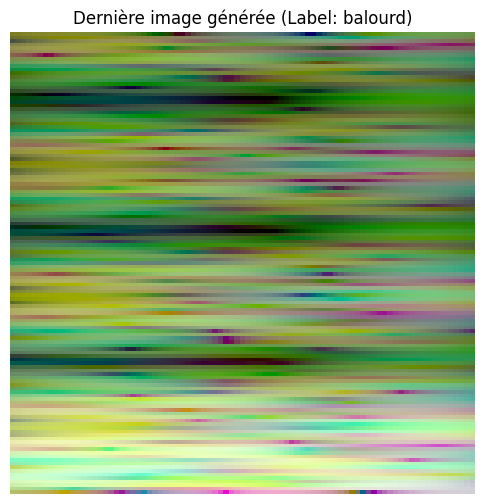

Dimensions finales de l'image : (85, 129)
L'image doit être colorée et avoir une largeur > 30 pixels.


In [4]:
# Affichage de la dernière image générée pour contrôle
if 'img' in locals():
    plt.figure(figsize=(6, 6))
    plt.imshow(img, aspect='auto')
    plt.title(f"Dernière image générée (Label: {category})")
    plt.axis('off')
    plt.show()

    print(f"Dimensions finales de l'image : {img.size}")
    print("L'image doit être colorée et avoir une largeur > 30 pixels.")